Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [2]:
run ../util/setupConsole_su

In [3]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSacks = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'


In [4]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [5]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [6]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [7]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [8]:
sacksMaizeNc = xr.open_dataset('%s/sacks/%s.crop.calendar.fill.nc'%(dirSacks, crop))
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

In [9]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [10]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_ef_grow = xr.Dataset()
cmip6_mrso_grow = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_evspsblveg_grow = xr.Dataset()
cmip6_evspsblsoi_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

ef_m = 0
mrso_m = 0
pr_m = 0
tran_m = 0
evspsblveg_m = 0
evspsblsoi_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow = ds_global_ef
        else:
            cmip6_ef_grow = xr.concat([cmip6_ef_grow, ds_global_ef], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))
        
        if mrso_m == 0:
            cmip6_mrso_grow = ds_global_mrso
        else:
            cmip6_mrso_grow = xr.concat([cmip6_mrso_grow, ds_global_mrso], dim='model')
        mrso_m += 1
    else:
        print('skipping mrso %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
    else:
        print('skipping tran %s'%model)
        
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblveg_m == 0:
            cmip6_evspsblveg_grow = ds_global_evspsblveg
        else:
            cmip6_evspsblveg_grow = xr.concat([cmip6_evspsblveg_grow, ds_global_evspsblveg], dim='model')
        evspsblveg_m += 1
    else:
        print('skipping evspsblveg %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblsoi_m == 0:
            cmip6_evspsblsoi_grow = ds_global_evspsblsoi
        else:
            cmip6_evspsblsoi_grow = xr.concat([cmip6_evspsblsoi_grow, ds_global_evspsblsoi], dim='model')
        evspsblsoi_m += 1
    else:
        print('skipping evspsblsoi %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
    else:
        print('skipping cropFrac %s'%model)


skipping tran access-cm2
skipping evspsblveg access-cm2
skipping evspsblsoi access-cm2
skipping tran access-esm1-5
skipping evspsblveg access-esm1-5
skipping mrso awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
skipping tran awi-cm-1-1-mr
skipping evspsblveg awi-cm-1-1-mr
skipping evspsblsoi awi-cm-1-1-mr
skipping cropFrac awi-cm-1-1-mr
skipping pr bcc-csm2-mr
skipping cropFrac bcc-csm2-mr
skipping cropFrac bcc-esm1
skipping tran ec-earth3
skipping evspsblveg ec-earth3
skipping evspsblsoi ec-earth3
skipping cropFrac ec-earth3
skipping ef gfdl-cm4
skipping pr gfdl-cm4
skipping evspsblveg gfdl-cm4
skipping evspsblsoi gfdl-cm4
skipping ef gfdl-esm4
skipping evspsblveg gfdl-esm4
skipping evspsblsoi gfdl-esm4
skipping mrso giss-e2-1-g
skipping pr giss-e2-1-g
skipping evspsblveg giss-e2-1-g
skipping evspsblsoi giss-e2-1-g
skipping cropFrac giss-e2-1-g
skipping ef kace-1-0-g
skipping mrso kace-1-0-g
skipping tran kace-1-0-g
skipping cropFrac kace-1-0-g
skipping evspsblveg fgoals-g3
skipping evspsblso

In [11]:
# load era5 growing season temps

era5_tasmax_grow_max_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region))
era5_tasmax_grow_mean_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s.nc'%(crop,region))
era5_ef_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
era5_pr_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_regrid_%s.nc'%(crop,region))
era5_tran_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_regrid_%s.nc'%(crop,region))
era5_evap_from_canopy_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s.nc'%(crop,region))
era5_evap_from_soil_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s.nc'%(crop,region))


In [12]:
# load gldas

gldas_noah_tran_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_tran_grow_mean_regrid_%s.nc'%('NOAH',crop,region))
gldas_noah_soil_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_soil_evap_grow_mean_regrid_%s.nc'%('NOAH', crop,region))
gldas_noah_canopy_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_canopy_evap_grow_mean_regrid_%s.nc'%('NOAH',crop,region))
gldas_noah_et_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_et_grow_mean_regrid_%s.nc'%('NOAH',crop,region))

gldas_vic_tran_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_tran_grow_mean_regrid_%s.nc'%('VIC',crop,region))
gldas_vic_soil_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_soil_evap_grow_mean_regrid_%s.nc'%('VIC', crop,region))
gldas_vic_canopy_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_canopy_evap_grow_mean_regrid_%s.nc'%('VIC',crop,region))
gldas_vic_et_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_et_grow_mean_regrid_%s.nc'%('VIC',crop,region))

gldas_tran_grow_mean_regrid = (gldas_noah_tran_grow_mean_regrid.evap_grow_mean.values + gldas_vic_tran_grow_mean_regrid.evap_grow_mean.values)/2
gldas_soil_evap_grow_mean_regrid = (gldas_noah_soil_evap_grow_mean_regrid.evap_grow_mean.values + gldas_vic_soil_evap_grow_mean_regrid.evap_grow_mean.values)/2
gldas_canopy_evap_grow_mean_regrid = (gldas_noah_canopy_evap_grow_mean_regrid.evap_grow_mean.values + gldas_vic_canopy_evap_grow_mean_regrid.evap_grow_mean.values)/2
gldas_et_grow_mean_regrid = (gldas_noah_et_grow_mean_regrid.evap_grow_mean.values + gldas_vic_et_grow_mean_regrid.evap_grow_mean.values)/2

In [13]:
# load pre-calculated bias by year

# monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups


yearly_tasmax_grow_max_bias = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_max_bias_cpc = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_ef_grow_bias = np.full([len(cmip6_models), era5_ef_grow_regrid.time.values.shape[0], \
                                   era5_ef_grow_regrid.lat.values.shape[0], \
                                   era5_ef_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias_gpcp = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

yearly_tran_grow_bias = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)
yearly_tran_grow_bias_rel = np.full([len(cmip6_models), era5_tran_grow_regrid.time.values.shape[0], \
                                   era5_tran_grow_regrid.lat.values.shape[0], \
                                   era5_tran_grow_regrid.lon.values.shape[0]], np.nan)

yearly_evap_from_canopy_grow_bias = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_canopy_grow_bias_rel = np.full([len(cmip6_models), era5_evap_from_canopy_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)

yearly_evap_from_soil_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)
yearly_evap_from_soil_grow_bias_rel = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

yearly_tran_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_canopy_evap_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_soil_evap_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)

yearly_et_grow_bias_gldas = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)


yearly_lai_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.time.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)

    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-cpc-tasmax-grow-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias_cpc[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_ef_grow_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_pr_grow_bias.shape[1]):
                yearly_pr_grow_bias_rel[m, y, :, :] = yearly_pr_grow_bias[m, y, :, :]/np.nanmean(era5_pr_grow_regrid.pr_grow_mean, axis=0)
                
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gpcp-pr-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gpcp-pr-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias_gpcp[m, :, :, :] = pickle.load(f)
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-tran-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_tran_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_tran_grow_bias.shape[1]):
                yearly_tran_grow_bias_rel[m, y, :, :] = yearly_tran_grow_bias[m, y, :, :]/-np.nanmean(era5_tran_grow_regrid.trans_grow_mean, axis=0)
                
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-evap_from_canopy-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-evap_from_canopy-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_evap_from_canopy_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_evap_from_canopy_grow_bias.shape[1]):
                yearly_evap_from_canopy_grow_bias_rel[m, y, :, :] = yearly_evap_from_canopy_grow_bias[m, y, :, :]/-np.nanmean(era5_evap_from_canopy_grow_regrid.evap_grow_mean, axis=0)
            
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-evap_from_soil-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-evap_from_soil-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_evap_from_soil_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_evap_from_soil_grow_bias.shape[1]):
                yearly_evap_from_soil_grow_bias_rel[m, y, :, :] = yearly_evap_from_soil_grow_bias[m, y, :, :]/-np.nanmean(era5_evap_from_soil_grow_regrid.evap_grow_mean, axis=0)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-tran-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-tran-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_tran_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-canopy-evap-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-canopy-evap-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_canopy_evap_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-soil-evap-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-soil-evap-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_soil_evap_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-gldas-et-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-gldas-et-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_et_grow_bias_gldas[m, :, :, :] = pickle.load(f)
    
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-lai-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-lai-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_lai_grow_bias[m, :, :, :] = pickle.load(f)
            
# eliminate huge bias grid cells
# yearly_tasmax_grow_max_bias[abs(yearly_tasmax_grow_max_bias)>10]=np.nan

loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr
loading yearly bias for bcc-esm1
loading yearly bias for canesm5
loading yearly bias for ec-earth3
loading yearly bias for gfdl-cm4
loading yearly bias for gfdl-esm4
loading yearly bias for giss-e2-1-g
loading yearly bias for kace-1-0-g
loading yearly bias for fgoals-g3
loading yearly bias for inm-cm5-0
loading yearly bias for ipsl-cm6a-lr
loading yearly bias for miroc6
loading yearly bias for mpi-esm1-2-hr
loading yearly bias for mpi-esm1-2-lr
loading yearly bias for mri-esm2-0
loading yearly bias for noresm2-lm
loading yearly bias for noresm2-mm
loading yearly bias for sam0-unicon


In [14]:
et_bias_era5 = yearly_tran_grow_bias + yearly_evap_from_canopy_grow_bias + yearly_evap_from_soil_grow_bias

In [15]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

def plot_polygon(ax, sub_region):
    """
    https://groups.google.com/forum/#!topic/scitools-iris/LxR0EbQolyE
    Note:
    ----
    order is important:
        lower-left, upper-left, upper-right, lower-right
        2 -- 3
        |    |
        1 -- 4
    """
    # ax = fig.axes[0]
    lats = [sub_region.latmin, sub_region.latmin, sub_region.latmax, sub_region.latmax]
    lons = [sub_region.lonmin, sub_region.lonmax, sub_region.lonmax, sub_region.lonmin]
    ring = LinearRing(list(zip(lons, lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=2)
    return ax


Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

region_us = Region(
    region_name="Midwest",
    lonmin = -115,
    lonmax = -80,
    latmin = 30,
    latmax = 55,
)

region_europe = Region(
    region_name="Europe",
    lonmin = 0,
    lonmax = 60,
    latmin = 35,
    latmax = 55,
)

region_india = Region(
    region_name="India",
    lonmin = 68,
    lonmax = 90,
    latmin = 5,
    latmax = 35,
)

region_china = Region(
    region_name="China",
    lonmin = 100,
    lonmax = 130,
    latmin = 20,
    latmax = 48,
)

region_sahel = Region(
    region_name="Sahel",
    lonmin = -15,
    lonmax = 50,
    latmin = 2,
    latmax = 17,
)

region_sa = Region(
    region_name="SA",
    lonmin = -68,
    lonmax = -50,
    latmin = -48,
    latmax = -25,
)

In [16]:
import numpy.ma as ma

crop_area_mask = crop_all_area_regrid.copy()
crop_area_mask[crop_area_mask == 0] = False
crop_area_mask[np.isnan(crop_area_mask)] = False
crop_area_mask[crop_area_mask > 0] = True
crop_area_mask = ma.make_mask(crop_area_mask)

In [17]:

era5_t_et = xr.open_dataset('era5/growing_season/era5_t_et_grow_%s.nc'%region)

    
cmip6_t_et_grow = xr.Dataset()
cmip6_t_et_grow_bias = np.full([len(cmip6_models), era5_evap_from_soil_grow_regrid.lat.values.shape[0], \
                                   era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

m = 0
for model in cmip6_models:

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_t_et_mon_global_%s_regrid.nc'%(crop, model)):
        print('skipping t_et %s'%model)
    else:
        ds_t_et = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_t_et_mon_global_%s_regrid.nc'%(crop, model))

        if m == 0:
            cmip6_t_et_grow = ds_t_et
            cmip6_t_et_grow_bias[m, :, :] = ds_t_et.t_et_grow_mean.mean(dim='time') - era5_t_et.t_et_grow_mean.mean(dim='time')
        else:
            cmip6_t_et_grow = xr.concat([cmip6_t_et_grow, ds_t_et], dim='model')
            cmip6_t_et_grow_bias[m, :, :] = ds_t_et.t_et_grow_mean.mean(dim='time') - era5_t_et.t_et_grow_mean.mean(dim='time')
        
        m += 1
            
    
    


skipping t_et access-cm2
skipping t_et access-esm1-5
skipping t_et awi-cm-1-1-mr
skipping t_et ec-earth3
skipping t_et gfdl-cm4
skipping t_et gfdl-esm4
skipping t_et giss-e2-1-g
skipping t_et kace-1-0-g
skipping t_et fgoals-g3
skipping t_et inm-cm5-0
skipping t_et mpi-esm1-2-hr
skipping t_et mpi-esm1-2-lr
skipping t_et noresm2-lm
skipping t_et noresm2-mm
skipping t_et sam0-unicon


0.3834225336648249


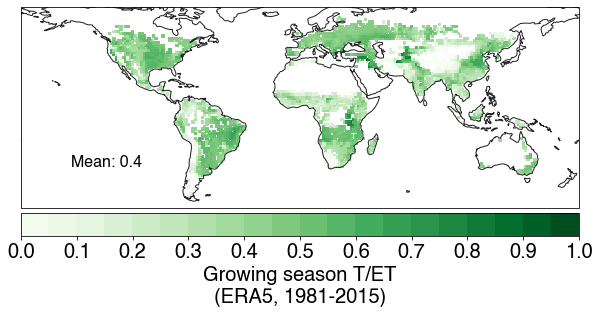

In [164]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = ds_t_et.t_et_grow_mean.mean(dim='time').values
data[~crop_area_mask] = np.nan
data[data==0] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season T/ET\n(ERA5, 1981-2015)', fontsize=20)

# plt.savefig('tran-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

-0.25896343863076476


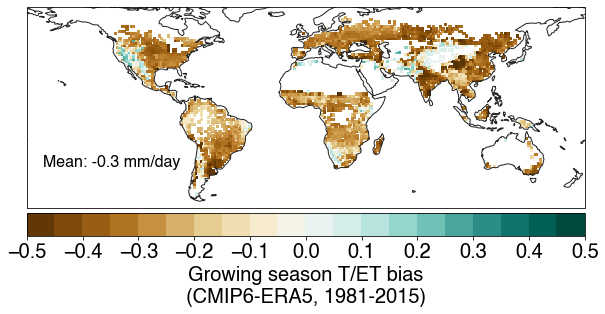

In [165]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_t_et_grow_bias, axis=0)
data[~crop_area_mask] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season T/ET bias\n(CMIP6-ERA5, 1981-2015)', fontsize=20)

# plt.savefig('tran-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

-1.695787486383605


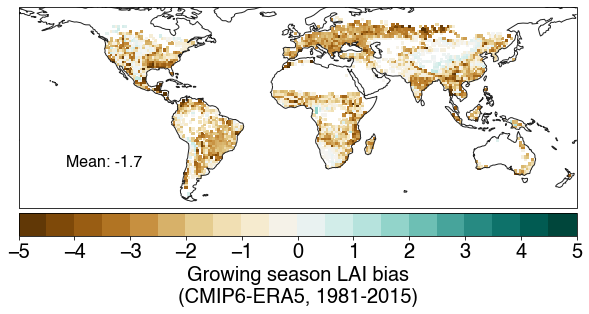

In [166]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -5
v2 = 5.01
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_lai_grow_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season LAI bias\n(CMIP6-ERA5, 1981-2015)', fontsize=20)

# plt.savefig('lai-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

-0.41216049680234534


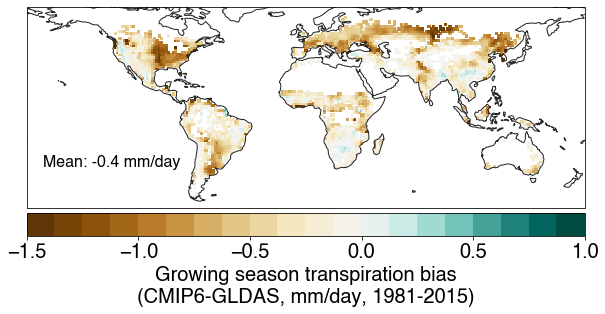

In [18]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_tran_grow_bias_gldas, axis=1), axis=0)
data[~crop_area_mask] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season transpiration bias\n(CMIP6-GLDAS, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('tran-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

0.09846945794446745


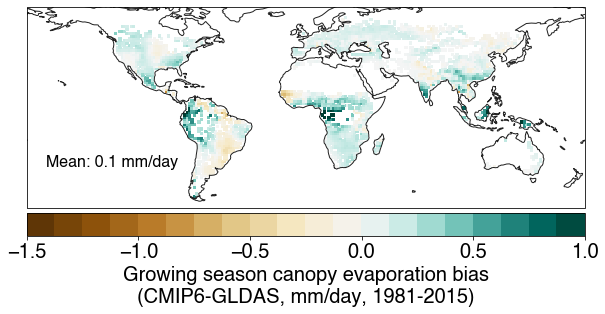

In [20]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_canopy_evap_grow_bias_gldas, axis=1), axis=0)
data[~crop_area_mask] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season canopy evaporation bias\n(CMIP6-GLDAS, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('tran-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

0.5998112289550328


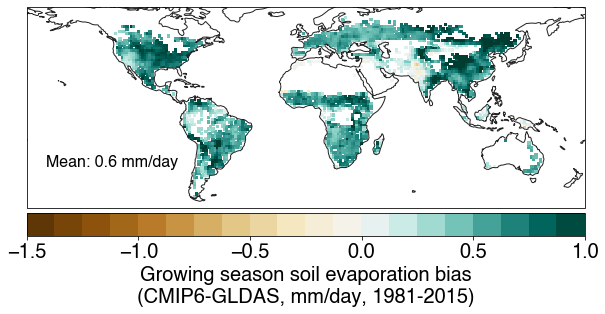

In [21]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_soil_evap_grow_bias_gldas, axis=1), axis=0)
data[~crop_area_mask] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season soil evaporation bias\n(CMIP6-GLDAS, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('tran-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

-0.5824808834751621


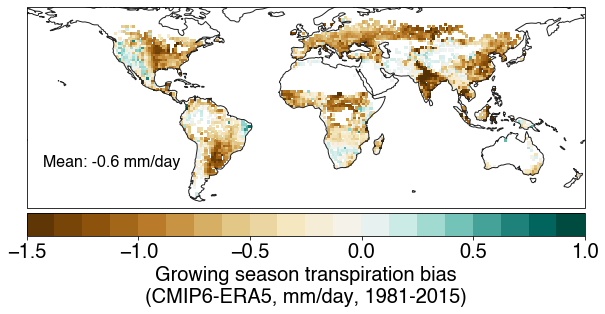

In [167]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_tran_grow_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan
print(np.nanmean(data))

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season transpiration bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('tran-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

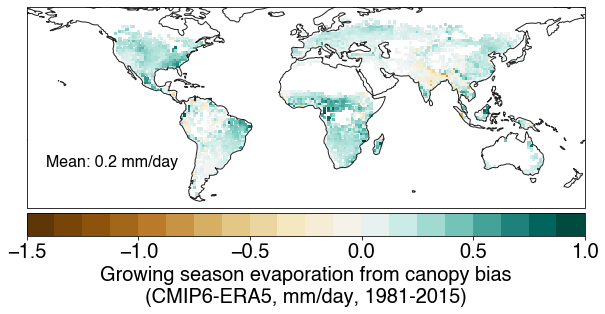

In [168]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
data = np.nanmean(np.nanmean(yearly_evap_from_canopy_grow_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)    

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season evaporation from canopy bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('evap-canopy-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

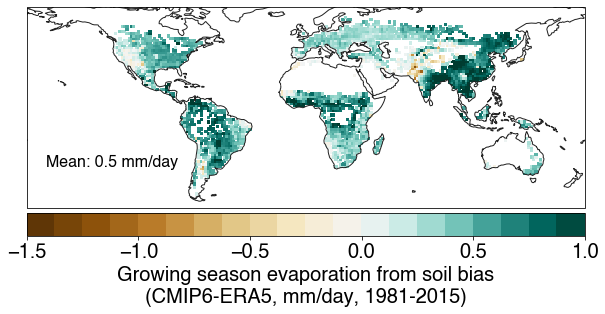

In [169]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_evap_from_soil_grow_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season evaporation from soil bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('evap-soil-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

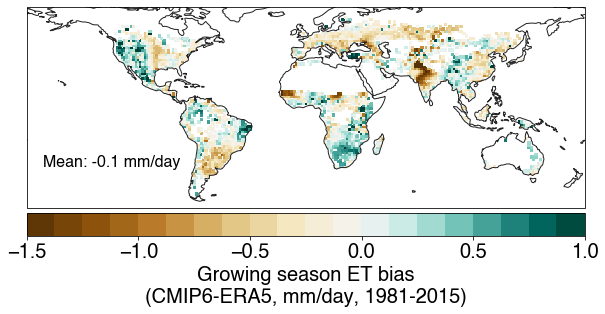

In [170]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(et_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season ET bias\n(CMIP6-ERA5, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('et-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

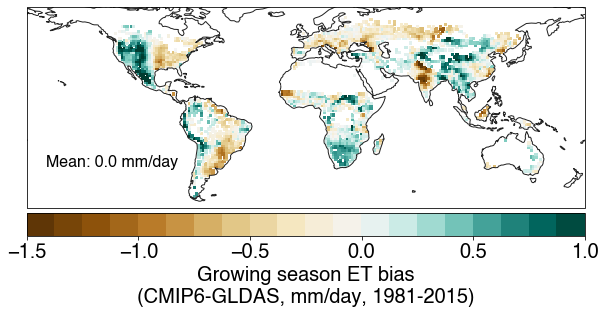

In [171]:


plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.01
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(np.nanmean(yearly_et_grow_bias_gldas, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], data, \
                 cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season ET bias\n(CMIP6-GLDAS, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('et-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

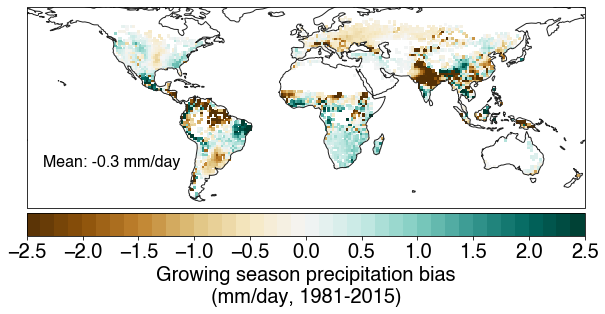

In [172]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -2.5
v2 = 2.51
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')


data = np.nanmean(np.nanmean(yearly_pr_grow_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season precipitation bias\n(mm/day, 1981-2015)', fontsize=20)

# plt.savefig('pr-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

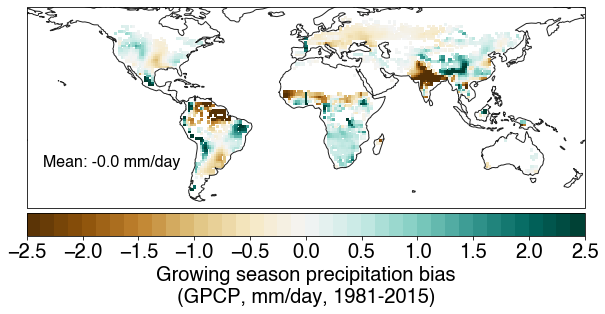

In [173]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -2.5
v2 = 2.51
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')


data = np.nanmean(np.nanmean(yearly_pr_grow_bias_gpcp, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.1f mm/day'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season precipitation bias\n(GPCP, mm/day, 1981-2015)', fontsize=20)

# plt.savefig('pr-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

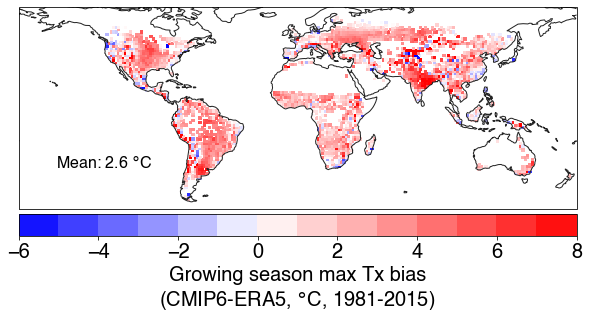

In [174]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -6
v2 = 8.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
plt.text(-125, -30, 'Mean: %.1f $\degree$C'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season max Tx bias\n(CMIP6-ERA5, $\degree$C, 1981-2015)', fontsize=20)

plt.savefig('max-tx-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

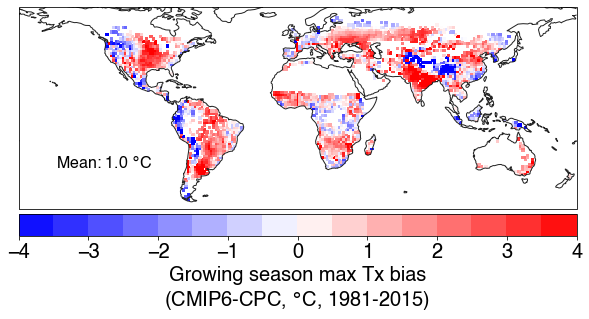

In [175]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -4
v2 = 4.01
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias_cpc, axis=1), axis=0)
data[~crop_area_mask] = np.nan

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 data, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
plt.text(-125, -30, 'Mean: %.1f $\degree$C'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season max Tx bias\n(CMIP6-CPC, $\degree$C, 1981-2015)', fontsize=20)

# plt.savefig('max-tx-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

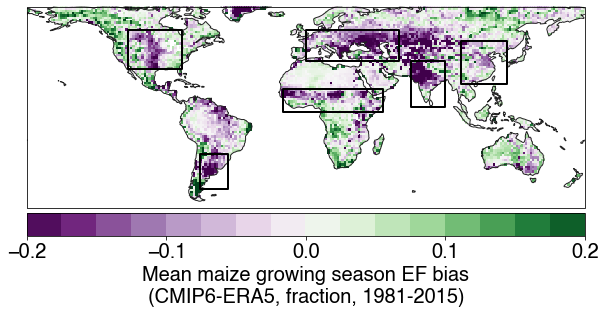

In [176]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])
v1 = -.2
v2 = .21
vstep = .025
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 np.nanmedian(np.nanmean(yearly_ef_grow_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean maize growing season EF bias\n(CMIP6-ERA5, fraction, 1981-2015)', fontsize=20)

plt.savefig('ef-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

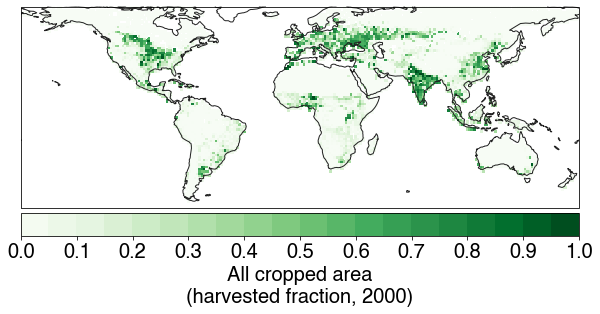

In [177]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], crop_all_area_regrid, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

# plot_polygon(ax, region_us)
# plot_polygon(ax, region_europe)
# plot_polygon(ax, region_india)
# plot_polygon(ax, region_china)
# plot_polygon(ax, region_sahel)
# plot_polygon(ax, region_sa)
# add_sub_region_box(ax, region_us)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('All cropped area\n(harvested fraction, 2000)', fontsize=20)



plt.savefig('cropped-area-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

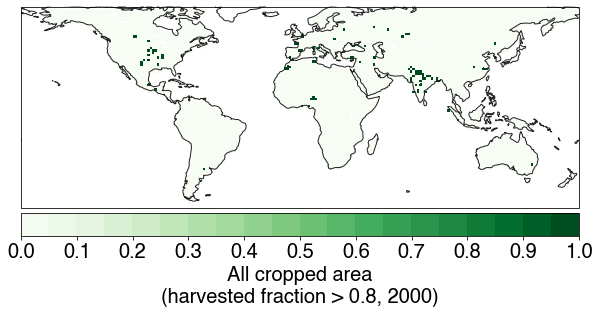

In [178]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

# bins = [0,.01,.05,.1,.2,.3, .4, .5, .6, .7, .8]

v1 = 0
v2 = 1.01
vstep = .05
vlabelstep = .1

crop_all_area_regrid_sel = crop_all_area_regrid.copy()

for xlat in range(crop_all_area_regrid_sel.shape[0]):
    for ylon in range(crop_all_area_regrid_sel.shape[1]):
        if np.isnan(crop_all_area_regrid_sel[xlat, ylon]): continue
            
        if crop_all_area_regrid_sel[xlat, ylon] > 0.8:# and crop_all_area_regrid_sel[xlat, ylon] <= 0.8:
            crop_all_area_regrid_sel[xlat, ylon] = 1
            
        else:
            crop_all_area_regrid_sel[xlat, ylon] = 0

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], crop_all_area_regrid_sel, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('All cropped area\n(harvested fraction > 0.8, 2000)', fontsize=20)

plt.savefig('cropped-area-map-0.8plus.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

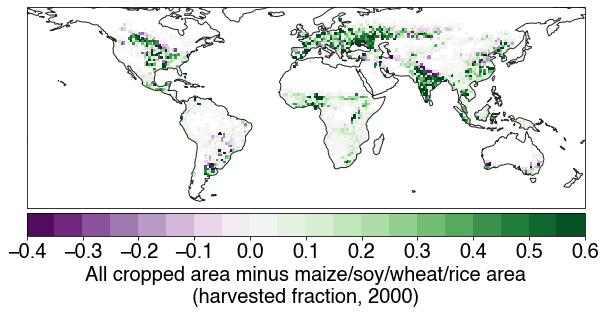

In [179]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = -.40
v2 = .61
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], crop_all_area_regrid-crop4_area_regrid_15, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('All cropped area minus maize/soy/wheat/rice area\n(harvested fraction, 2000)', fontsize=20)

In [180]:
# crop4_area_regrid_1d = np.reshape(crop4_area_regrid_15, [crop4_area_regrid_15.size,1])
crop_all_area_regrid_1d = np.reshape(crop_all_area_regrid, [crop_all_area_regrid.size,1])

In [181]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)
    irrigation_data_regrid[irrigation_data_regrid == 0] = np.nan
    irrigation_data_regrid /= 100
    irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.shape[0]*irrigation_data_regrid.shape[1],1])

CPU times: user 1.63 ms, sys: 0 ns, total: 1.63 ms
Wall time: 43.7 ms


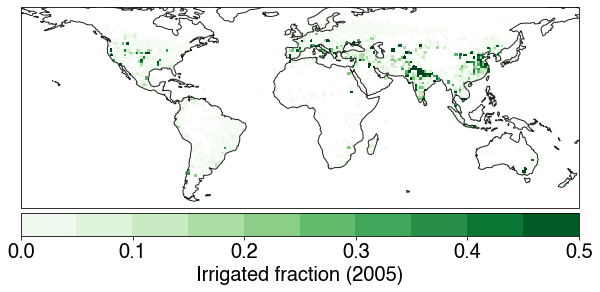

In [182]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], irrigation_data_regrid, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Irrigated fraction (2005)', fontsize=20)

In [183]:
cmip6_ha_bias = np.full([len(cmip6_models), cmip6_cropFrac_grow.lat.size, cmip6_cropFrac_grow.lon.size], np.nan)

cmip6_cropFrac_grow_mean = cmip6_cropFrac_grow.grow_cropFrac.mean(dim='time').values

m_rel = 0
for m in range(len(cmip6_models)):
    if cmip6_models[m] in cmip6_cropFrac_grow.model.values:
        print('processing model %s'%cmip6_cropFrac_grow.model[m_rel])
        for xlat in range(cmip6_ha_bias.shape[1]):
            for ylon in range(cmip6_ha_bias.shape[2]):
                cmip6_ha_bias[m_rel, xlat, ylon] = cmip6_cropFrac_grow_mean[m_rel, xlat, ylon]-crop_all_area_regrid[xlat, ylon]*100
        m_rel += 1

processing model <xarray.DataArray 'model' ()>
array('access-cm2', dtype='<U10')
Coordinates:
    model    <U10 'access-cm2'
processing model <xarray.DataArray 'model' ()>
array('access-esm1-5', dtype='<U13')
Coordinates:
    model    <U13 'access-esm1-5'
processing model <xarray.DataArray 'model' ()>
array('canesm5', dtype='<U7')
Coordinates:
    model    <U7 'canesm5'
processing model <xarray.DataArray 'model' ()>
array('gfdl-cm4', dtype='<U8')
Coordinates:
    model    <U8 'gfdl-cm4'
processing model <xarray.DataArray 'model' ()>
array('gfdl-esm4', dtype='<U9')
Coordinates:
    model    <U9 'gfdl-esm4'
processing model <xarray.DataArray 'model' ()>
array('inm-cm5-0', dtype='<U9')
Coordinates:
    model    <U9 'inm-cm5-0'
processing model <xarray.DataArray 'model' ()>
array('ipsl-cm6a-lr', dtype='<U12')
Coordinates:
    model    <U12 'ipsl-cm6a-lr'
processing model <xarray.DataArray 'model' ()>
array('mpi-esm1-2-hr', dtype='<U13')
Coordinates:
    model    <U13 'mpi-esm1-2-hr'
proces

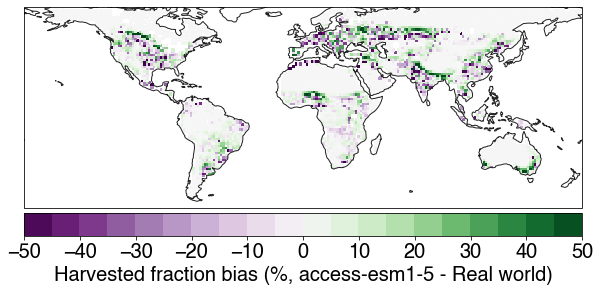

In [184]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

    
ax.set_extent([-180, -180, 70, -60])


m = 1

v1 = -50
v2 = 50.1
vstep = 5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], cmip6_ha_bias[m,:,:], cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Harvested fraction bias (%%, %s - Real world)'%cmip6_models[m], fontsize=20)

# plt.savefig('ha-bias-map-%s.png'%cmip6_models[m], format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)